# Week 5 COLAB: AM206

This tutorial has two parts:


1.   Autograd tutorial on automatic differentiation. This is general software that contains the essential algorithm (back-prop) used in deep learning. The tutorial was modified from Material we found on the web, which was written by David Duvenaud.
2.   Adjoint method for optimizing ODEs. As we have emphasized in class, the back prop algorithm is equivalent to a classic algorithm for solving optimization problems for ordinary differential equations. In the second part of this tutorial we will implement that.






## Autograd Tutorial

This tutorial was modified from material on the web, I believe written by David Duvenaud. Large parts of the text and of the code were taken from a course that David taught at the University of Toronto.

References:

* Ryan Adams' talk: https://www.youtube.com/watch?v=sq2gPzlrM0g
* Backpropagation notes from Stanford's CS231n: http://cs231n.github.io/optimization-2/
* Autograd Github Repository (contains a tutorial and examples): https://github.com/HIPS/autograd

## Approaches for Computing Derivatives

* **Symbolic differentiation:** automatic manipulation of mathematical expressions to get derivatives
    - Takes a math expression and returns a math expression: $f(x) = x^2 \rightarrow \frac{df(x)}{dx} = 2x$
    - Used in Mathematica, Maple, Sympy, etc.
* **Numeric differentiation:** Approximating derivatives by finite differences:
$$
\frac{\partial}{\partial x_i} f(x_1, \dots, x_N) = \lim_{h \to 0} \frac{f(x_1, \dots, x_i + h, \dots, x_N) - f(x_1, \dots, x_i - h, \dots, x_N)}{2h}
$$
* **Automatic differentiation:** Takes code that computes a function and returns code that computes the derivative of that function.
    - Reverse Mode AD: A method to get exact derivatives efficiently, by storing information as you go forward that you can reuse as you go backwards
    - "The goal isn't to obtain closed-form solutions, but to be able to wirte a program that efficiently computes the derivatives." - (See eg Lecture 6 Slides from Univ. Toronto)http://www.cs.toronto.edu/~rgrosse/courses/csc321_2017/slides/lec6.pdf
 

## Reverse Mode Automatic Differentiation

In machine learning, we have functions that have large fan-in, e.g. a neural net can have millions of parameters, that all squeeze down to one scalar that tells you how well it predicts something.  cats.

### General Idea for Implementation

* Create a "tape" data structure that tracks the operations performed in computing a function
* Overload primitives to:
    - Add themselves to the tape when called
    - Compute gradients with respect to their local inputs
* _Forward pass_ computes the function, and adds operations to the tape
* _Reverse pass_ accumulates the local gradients using the chain rule
* This is efficient for graphs with large fan-in, like most loss functions in ML

### Applications of Autograd
John Kitchen's group at CMU has good applications of the use of Autograd for solving differential equations and integrals, see this (link)http://kitchingroup.cheme.cmu.edu/blog/category/autograd/

## Autograd

* [Autograd](https://github.com/HIPS/autograd) is a Python package for automatic differentiation.
* To install Autograd:
                pip install autograd
* There are a lot of great [examples](https://github.com/HIPS/autograd/tree/master/examples) provided with the source code

### What can Autograd do?

From the Autograd Github repository:

* Autograd can automatically differentiate native Python and Numpy code.
* It can handle a large subset of Python's features, including loops, conditional statements (if/else), recursion and closures
* It can also compute higher-order derivatives
* It uses reverse-mode differentiation (a.k.a. backpropagation) so it can efficiently take gradients of scalar-valued functions with respect to array-valued arguments.



### Autograd Basic Usage

In [0]:
import autograd.numpy as np # Import thinly-wrapped numpy
from autograd import grad   # Basicallly the only function you need

In [0]:
# Define a function like normal, using Python and Numpy
def tanh(x):
    y = np.exp(-x)
    return (1.0 - y) / (1.0 + y)

# Create a *function* that computes the gradient of tanh
grad_tanh = grad(tanh)

# Evaluate the gradient at x = 1.0
print(grad_tanh(1.0))

# Compare to numeric gradient computed using finite differences
print((tanh(1.0001) - tanh(0.9999)) / 0.0002)

0.39322386648296376
0.39322386636453377


In [0]:
print(grad(np.cos)(5.),-np.sin(5.))

0.9589242746631385 0.9589242746631385


### Autograd vs Manual Gradients via Staged Computation

In this example, we will see how a complicated computation can be written as a composition of simpler functions, and how this provides a scalable strategy for computing gradients using the chain rule.

Say we want to write a function to compute the gradient of the *sigmoid function*:
$$
\sigma(x) = \frac{1}{1 + e^{-x}}
$$
We can write $\sigma(x)$ as a composition of several elementary functions, as $\sigma(x) = s(c(b(a(x))))$, where:

$$
a(x) = -x
$$

$$
b(a) = e^a
$$

$$
c(b) = 1 + b
$$

$$
s(c) = \frac{1}{c}
$$

Here, we have "staged" the computation such that it contains several intermediate variables, each of which are basic expressions for which we can easily compute the local gradients.

The input to this function is $x$, and the output is represented by node $s$. We wish compute the gradient of $s$ with respect to $x$, $\frac{\partial s}{\partial x}$. In order to make use of our intermediate computations, we can use the chain rule as follows:
$$
\frac{\partial s}{\partial x} = \frac{\partial s}{\partial c} \frac{\partial c}{\partial b} \frac{\partial b}{\partial a} \frac{\partial a}{\partial x}
$$

<!--
Given a vector-to-scalar function, $\mathbb{R}^D \to \mathbb{R}$, composed of a set of primitive functions
$\mathbb{R}^M \to \mathbb{R}^N$ (for various $M$, $N$), the gradient of the composition is given by the product of the gradients of the primitive functions, according to the chain rule. But the chain rule doesn’t prescribe the order in which to multiply the gradients. From the perspective of computational complexity, the order makes all the
difference.
-->

In [0]:
def grad_sigmoid_manual(x):
    """Implements the gradient of the logistic sigmoid function 
    $\sigma(x) = 1 / (1 + e^{-x})$ using staged computation
    """
    # Forward pass, keeping track of intermediate values for use in the 
    # backward pass
    a = -x         # -x in denominator
    b = np.exp(a)  # e^{-x} in denominator
    c = 1 + b      # 1 + e^{-x} in denominator
    s = 1.0 / c    # Final result, 1.0 / (1 + e^{-x})
    
    # Backward pass
    dsdc = (-1.0 / (c**2))
    dsdb = dsdc * 1
    dsda = dsdb * np.exp(a)
    dsdx = dsda * (-1)
    
    return dsdx


def sigmoid(x):
    y = 1.0 / (1.0 + np.exp(-x))
    return y

# Instead of writing grad_sigmoid_manual manually, we can use 
# Autograd's grad function:
grad_sigmoid_automatic = grad(sigmoid)

# Compare the results of manual and automatic gradient functions:
print(grad_sigmoid_automatic(2.0))
print(grad_sigmoid_manual(2.0))

0.1049935854035065
0.1049935854035065


### Gradients of Data Structures: `flatten` and `unflatten`

Autograd allows you to compute gradients for many different data structures.
Autograd provides a lot of flexibility in the types of data structures you can use to store the parameters of your model. This flexibility is achieved through the `flatten` function, which converts any nested combination of lists, tuples, arrays, or dicts into a 1-dimensional Numpy array.

The idea is that we know how to compute gradients of vectors, and we can convert many data structures into vectors (i.e. "flatten" the data structures). 

- **Actually there are many other ways to flatten an array.** The autograd team still preserves this function.

In [0]:
import autograd.numpy as np
import autograd.numpy.random as npr
from autograd import grad
from autograd.misc.flatten import flatten

A list of matrices (of different sizes):

In [0]:
params = [npr.randn(3,3), npr.randn(4,4), npr.randn(3,3)]
flat_params, unflatten_func = flatten(params)
print('Flattened: {}'.format(flat_params))
print('Unflattened: {}'.format(unflatten_func(flat_params)))

Flattened: [-0.98034277 -0.54553395  1.69312367  0.2968163  -1.02000912 -1.01207054
  1.70703696  1.81041805 -0.92433532  0.05236841 -0.19019408 -0.4913118
 -0.96283074 -0.83071431 -0.44841592 -0.9505029  -1.25193859  0.34491733
  2.05251698 -1.47977138 -0.42059906  1.9629321  -0.68239644 -0.75415354
 -1.51664797  0.02001511  1.34906595 -1.05308974 -0.54593937  1.51462912
  0.62820323 -0.26265882  1.60072202 -0.71085177]
Unflattened: [array([[-0.98034277, -0.54553395,  1.69312367],
       [ 0.2968163 , -1.02000912, -1.01207054],
       [ 1.70703696,  1.81041805, -0.92433532]]), array([[ 0.05236841, -0.19019408, -0.4913118 , -0.96283074],
       [-0.83071431, -0.44841592, -0.9505029 , -1.25193859],
       [ 0.34491733,  2.05251698, -1.47977138, -0.42059906],
       [ 1.9629321 , -0.68239644, -0.75415354, -1.51664797]]), array([[ 0.02001511,  1.34906595, -1.05308974],
       [-0.54593937,  1.51462912,  0.62820323],
       [-0.26265882,  1.60072202, -0.71085177]])]


/anaconda3/envs/pymatgen3/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]


### Gradient Functions

There are several functions that compute gradients, which have different signatures

* `grad(fun, argnum=0)`
    - Returns a function which computes the gradient of `fun` with respect to
      positional argument number `argnum`. The returned function takes the same
      arguments as `fun`, but returns the gradient instead. The function `fun`
      should be scalar-valued. The gradient has the same type as the argument.
* `grad_named(fun, argname)`
    - Takes gradients with respect to a named argument.
* `multigrad(fun, argnums=[0])`
    - Takes gradients wrt multiple arguments simultaneously.
* `multigrad_dict(fun)`
    - Takes gradients with respect to all arguments simultaneously, and returns a dict mapping `argname` to `gradval`

## Modularity: Implementing Custom Gradients

The implementation of Autograd is simple, readable, and extensible!

One thing you can do is define custom gradients for your own functions. There are several reasons you might want to do this, including:

1. **Speed:** You may know a faster way to compute the gradient for a specific function.
2. **Numerical Stability**
3. When your code depends on **external library calls**

The `@primitive` decorator wraps a function so that its gradient can be specified manually and its invocation can be recorded.

In [0]:
import autograd.numpy as np
import autograd.numpy.random as npr
from autograd import grad, primitive
from autograd.util import quick_grad_check

# From the Autograd examples:
# @primitive tells autograd not to look inside this function, but instead
# to treat it as a black box, whose gradient might be specified later.
@primitive
def logsumexp(x):
    """Numerically stable log(sum(exp(x)))"""
    max_x = np.max(x)
    return max_x + np.log(np.sum(np.exp(x - max_x)))

# Next, we write a function that specifies the gradient with a closure.
def make_grad_logsumexp(ans, x):
    # If you want to be able to take higher-order derivatives, then all the
    # code inside this function must be itself differentiable by autograd.
    def gradient_product(g):
        return np.full(x.shape, g) * np.exp(x - np.full(x.shape, ans))
    return gradient_product

# Now we tell autograd that logsumexmp has a gradient-making function.
logsumexp.defgrad(make_grad_logsumexp)

/anaconda3/envs/pymatgen3/lib/python3.6/site-packages/autograd/core.py:308: UserWarning: 
The defgrad method is deprecated. See the update guide and tutorial:
https://github.com/HIPS/autograd/blob/master/docs/updateguide.md
https://github.com/HIPS/autograd/blob/master/docs/tutorial.md
  warnings.warn(deprecation_msg)


In [0]:
# Now we can use logsumexp() inside a larger function that we want to differentiate.
def example_func(y):
    z = y**2
    lse = logsumexp(z)
    return np.sum(lse)

grad_of_example = grad(example_func)
print("Gradient: ", grad_of_example(npr.randn(10)))

# Check the gradients numerically, just to be safe.
quick_grad_check(example_func, npr.randn(10))

Gradient:  [-0.02783314  1.16460432  0.02345465  0.00957014  0.19238063 -0.17134002
 -0.07414563  0.02454814  0.02704719  0.0707303 ]


/anaconda3/envs/pymatgen3/lib/python3.6/site-packages/autograd/util.py:28: UserWarning: 
The quick_grad_check function is deprecated. See the update guide:
https://github.com/HIPS/autograd/blob/master/docs/updateguide.md
  warnings.warn(deprecation_msg)


### Examples

The next three sections of the notebook show examples of using Autograd in the context of three problems:

1. **1-D linear regression**, where we try to fit a model to a function $y = wx + b$
2. **Linear regression using a polynomial feature map**, to fit a function of the form $y = w_0 + w_1 x + w_2 x^2 + \dots + w_M x^M$
3. **Nonlinear regression using a neural network**

#### Linear Regression

### Review

We are given a set of data points $\{ (x_1, t_1), (x_2, t_2), \dots, (x_N, t_N) \}$, where each point $(x_i, t_i)$ consists of an *input value* $x_i$ and a *target value* $t_i$. 

The **model** we use is:
$$
y_i = wx_i + b
$$

We want each predicted value $y_i$ to be close to the ground truth value $t_i$. In linear regression, we use squared error to quantify the disagreement between $y_i$ and $t_i$. The **loss function** for a single example is:
$$
\mathcal{L}(y_i,t_i) = \frac{1}{2} (y_i - t_i)^2
$$

The **cost function** is the loss averaged over all the training examples:
$$
\mathcal{E}(w,b) = \frac{1}{N} \sum_{i=1}^N \mathcal{L}(y_i, t_i) = \frac{1}{N} \sum_{i=1}^N \frac{1}{2} \left(wx_i + b - t_i \right)^2
$$

In [0]:
import autograd.numpy as np # Import wrapped NumPy from Autograd
import autograd.numpy.random as npr # For convenient access to numpy.random
from autograd import grad # To compute gradients

import matplotlib.pyplot as plt # For plotting

%matplotlib inline

## Generate Synthetic Data

We generate a synthetic dataset $\{ (x_i, t_i) \}$ by first taking the $x_i$ to be linearly spaced in the range $[0, 10]$ and generating the corresponding value of $t_i$ using the following equation (where $w = 4$ and $b=10$):
$$
t_i = 4 x_i + 10 + \epsilon
$$

Here, $\epsilon \sim \mathcal{N}(0, 2)$ (that is, $\epsilon$ is drawn from a Gaussian distribution with mean 0 and variance 2). This introduces some random fluctuation in the data, to mimic real data that has an underlying regularity, but for which individual observations are corrupted by random noise.

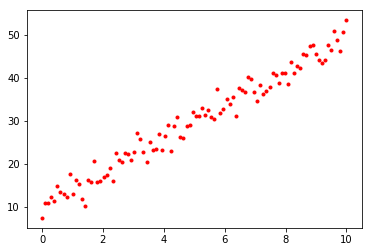

In [0]:
# In our synthetic data, we have w = 4 and b = 10
N = 100 # Number of training data points
x = np.linspace(0, 10, N)
t = 4 * x + 10 + npr.normal(0, 2, x.shape[0])
plt.plot(x, t, 'r.')

In [0]:
# Initialize random parameters
w = npr.normal(0, 1)
b = npr.normal(0, 1)
params = { 'w': w, 'b': b } # One option: aggregate parameters in a dictionary

def cost(params):
    y = params['w'] * x + params['b']
    return (1 / N) * np.sum(0.5 * np.square(y - t))

# Find the gradient of the cost function using Autograd
grad_cost = grad(cost) 

num_epochs = 1000  # Number of epochs of training
alpha = 0.01       # Learning rate

for i in range(num_epochs):
    # Evaluate the gradient of the current parameters stored in params
    cost_params = grad_cost(params)
    
    # Update parameters w and b
    params['w'] = params['w'] - alpha * cost_params['w']
    params['b'] = params['b'] - alpha * cost_params['b']

print(params)

{'w': 4.076557885127735, 'b': 9.238366645707936}


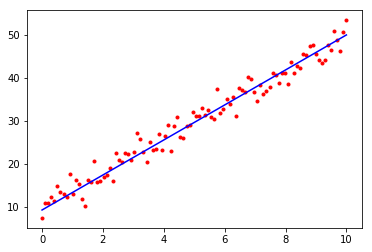

In [0]:
# Plot the training data again, together with the line defined by y = wx + b
# where w and b are our final learned parameters
plt.plot(x, t, 'r.')
plt.plot([0, 10], [params['b'], params['w'] * 10 + params['b']], 'b-')

## Linear Regression with a Feature Mapping

In this example we will fit a polynomial using linear regression with a polynomial feature mapping.
The target function is:

$$
t = x^4 - 10 x^2 + 10 x + \epsilon
$$

where $\epsilon \sim \mathcal{N}(0, 4)$. 

This is an example of a _generalized linear model_, in which we perform a fixed nonlinear transformation of the inputs $\mathbf{x} = (x_1, x_2, \dots, x_D)$, and the model is still linear in the _parameters_. We can define a set of _feature mappings_ (also called feature functions or basis functions) $\phi$ to implement the fixed transformations.

In this case, we have $x \in \mathbb{R}$, and we define the feature mapping:
$$
\mathbf{\phi}(x) = \begin{pmatrix}\phi_1(x) \\ \phi_2(x) \\ \phi_3(x) \\ \phi_4(x) \end{pmatrix} = \begin{pmatrix}1\\x\\x^2\\x^3\end{pmatrix}
$$

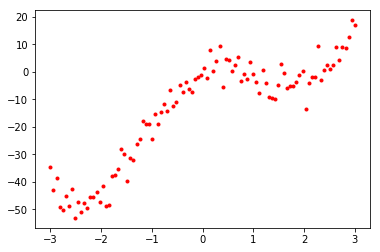

In [0]:
# Generate synthetic data
N = 100 # Number of data points
x = np.linspace(-3, 3, N) # Generate N values linearly-spaced between -3 and 3
t = x ** 4 - 10 * x ** 2 + 10 * x + npr.normal(0, 4, x.shape[0]) # Generate corresponding targets
plt.plot(x, t, 'r.') # Plot data points

In [0]:
M = 4 # Degree of polynomial to fit to the data (this is a hyperparameter)
feature_matrix = np.array([[item ** i for i in range(M+1)] for item in x]) # Construct a feature matrix 
W = npr.randn(feature_matrix.shape[-1])

def cost(W):
    y = np.dot(feature_matrix, W)
    return (1.0 / N) * np.sum(0.5 * np.square(y - t))

# Compute the gradient of the cost function using Autograd
cost_grad = grad(cost)

num_epochs = 10000
learning_rate = 0.001

# Manually implement gradient descent
for i in range(num_epochs):
    W = W - learning_rate * cost_grad(W)

# Print the final learned parameters.
print(W)

[-1.36394649  9.52788013 -9.56607407  0.06474176  0.96275857]


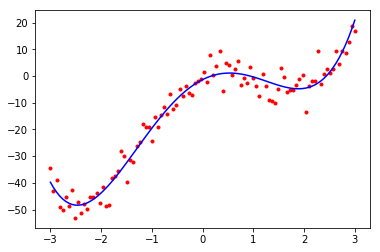

In [0]:
# Plot the original training data again, together with the polynomial we fit
plt.plot(x, t, 'r.')
plt.plot(x, np.dot(feature_matrix, W), 'b-')

## Have fun: Building MNIST classifier ALL from scratch

In [0]:
import os, gzip, struct, array
import autograd.numpy as np
from urllib.request import urlretrieve

### Download the data

In [0]:
def load_mnist():
    from keras.datasets import mnist
    from keras.utils import to_categorical
    (train_images, train_labels), (test_images, test_labels) = mnist.load_data()
    N_data = train_images.shape[0]
    return N_data, train_images.reshape(-1,784)/255.0, to_categorical(train_labels,10), \
test_images.reshape(-1,784)/255.0, to_categorical(test_labels,10)

In [0]:
"""A multi-layer perceptron for classification of MNIST handwritten digits."""
from __future__ import absolute_import, division
from __future__ import print_function
import autograd.numpy as np
import autograd.numpy.random as npr
from autograd.scipy.misc import logsumexp
from autograd import grad
from autograd.misc.flatten import flatten
from autograd.misc.optimizers import adam


def init_random_params(scale, layer_sizes, rs=npr.RandomState(0)):
    """Build a list of (weights, biases) tuples,
       one for each layer in the net."""
    return [(scale * rs.randn(m, n),   # weight matrix
             scale * rs.randn(n))      # bias vector
            for m, n in zip(layer_sizes[:-1], layer_sizes[1:])]

def neural_net_predict(params, inputs):
    """Implements a deep neural network for classification.
       params is a list of (weights, bias) tuples of each layer.
       inputs is an (N x D) matrix.
       returns normalized class log-probabilities."""
    for W, b in params:
        
        # outputs of current layer before the activation
        outputs = np.dot(inputs, W) + b
        
        # inputs to the next layer
        inputs = np.tanh(outputs)
    return outputs - 0*logsumexp(outputs, axis=1, keepdims=True)

def l2_norm(params):
    """Computes l2 norm of params by flattening them into a vector."""
    flattened, _ = flatten(params)
    return np.dot(flattened, flattened)

def loss(params, inputs, targets, L2_reg):
    rgl = L2_reg * l2_norm(params)
    crossE = -np.sum(neural_net_predict(params, inputs) * targets)
    return rgl + crossE

def accuracy(params, inputs, targets):
    target_class    = np.argmax(targets, axis=1)
    predicted_class = np.argmax(neural_net_predict(params, inputs), axis=1)
    return np.mean(predicted_class == target_class)


# Model parameters. `L2_reg` is `lambda` in L2-regularization
layer_sizes = [784, 200, 100, 10]
L2_reg = 1.0

# Training parameters
param_scale = 0.1
batch_size = 256
num_epochs = 15
step_size = 0.001

print("Loading training data...")
N, train_images, train_labels, test_images,  test_labels = load_mnist()

init_params = init_random_params(param_scale, layer_sizes)

num_batches = int(np.ceil(len(train_images) / batch_size))
def batch_indices(iter):
    idx = iter % num_batches
    return slice(idx * batch_size, (idx+1) * batch_size)

# Define training objective
def objective(params, iter):
    idx = batch_indices(iter)
    return loss(params, train_images[idx], train_labels[idx], L2_reg)

# Get gradient of objective using autograd.
objective_grad = grad(objective)

print("     Epoch     |    Train accuracy  |       Test accuracy  ")
def print_perf(params, iter, gradient):
    if iter % num_batches == 0:
        train_acc = accuracy(params, train_images, train_labels)
        test_acc  = accuracy(params, test_images, test_labels)
        print("{:15}|{:20}|{:20}".format(iter//num_batches, train_acc, test_acc))

# The optimizers provided can optimize lists, tuples, or dicts of parameters.
optimized_params = adam(objective_grad, init_params, step_size=step_size,
                        num_iters=num_epochs * num_batches, callback=print_perf)

Loading training data...
     Epoch     |    Train accuracy  |       Test accuracy  
              0| 0.06888333333333334|              0.0657
              1|             0.79325|              0.7922
              2|  0.8752666666666666|              0.8761
              3|  0.9062833333333333|               0.907
              4|  0.9200833333333334|              0.9196
              5|             0.92915|               0.928
              6|  0.9352833333333334|              0.9347
              7|              0.9406|              0.9398
              8|  0.9457166666666666|              0.9433
              9|  0.9497666666666666|              0.9473
             10|              0.9525|              0.9496
             11|              0.9555|              0.9524
             12|  0.9573166666666667|              0.9543
             13|             0.95915|              0.9555
             14|  0.9609833333333333|              0.9568


# Adjoint Method for Differential Equations

Applied to solving differential equations of the form $$ \frac{d^2x}{dt^2} + \omega^2 x = f(x),$$ where $f(x)$ is a polynomial of some fixed degree.

In [0]:
import autograd.numpy as np 
import scipy.integrate
from autograd import grad   
from autograd import elementwise_grad 
from autograd.extend import primitive
from autograd import jacobian as jac
odeint = primitive(scipy.integrate.odeint)
solve_bvp = primitive(scipy.integrate.solve_bvp)

import integrate
from integrate import odeint, solve_bvp

In [0]:
def poly(x,n,a):
    return sum([a[i]*x**i for i in range(n)])

In [0]:
grad_poly=grad(poly)

In [0]:
grad_poly(2.,2,[0,2])

2.0

In [0]:

def xDiffEq(xAndXDot, t, wSq, fCoefs):
    x, xDot = xAndXDot
    dydt = np.array([xDot, -wSq*x + poly(x,len(fCoefs),fCoefs)])
    return dydt

def solveDiffEq(y0,wSq,fCoefs,dT):
    maxT=10
    t = np.linspace(0, maxT, 100) #make maxT/dT points between 0 and maxT
    return odeint(xDiffEq, y0, t, args=(wSq, fCoefs))

def lambdaDiffEq(lAndlDot, t, xRev, wSq, fCoefs,maxT,tStart,tEnd,dT):
    l, lDot = lAndlDot
    tAgain = np.linspace(tStart,tEnd,(tEnd-tStart)/dT+1)[::-1] #reverses array
    tIndex = np.argmin(np.abs(tAgain-t))
    x = xRev[tIndex]
    dydt = [lDot, -wSq*l + l*grad_poly(x,len(fCoefs),fCoefs)]
    return dydt
def solveDiffEqLambda(revX,xDataEnd,wSq,fCoefs,dT,tStart,tEnd,maxT):
    y0 = [0, -2*(revX[0]-xDataEnd)]
    t = np.linspace(tStart,tEnd,(tEnd - tStart)/dT+1)[::-1] #reverses array
    return odeint(lambdaDiffEq, y0, t, args=(revX, wSq, fCoefs,maxT,tStart,tEnd,dT))

In [0]:
#as a check, try to solve a random equation we know the solution for. 
#For example, setting wSq = 33, f(x)=1+12x, x0 = 2, xDot0 = 5, we get
#x[t] -> 1/21 (1 + 41 Cos[Sqrt[21] t] + 5 Sqrt[21] Sin[Sqrt[21] t])
t = np.linspace(0, 10, 100) #make 100 points between 0 and 10
xCheck = solveDiffEq([2,5],33,[1,12,0,0,0,0,0],0.1)
xCheckMathematica = 1/21 * (1+41*np.cos(np.sqrt(21)*t) + 5*np.sqrt(21)*np.sin(np.sqrt(21)*t))
any(np.abs(xCheck[:,0] - xCheckMathematica)>1e-6 )==False #If this full expression returns True, then this checks out

True

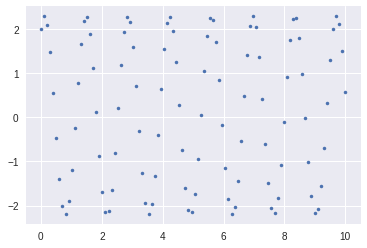

In [0]:
plt.plot(t,xCheck[:,0],'.')

In [0]:
def dCdWSq(x, lambdaT, dT):
    return dT*sum(x*lambdaT)

def dCdAlphaI(x, lambdaT, dT,i):
    return -dT*sum(lambdaT*x**i)

In [0]:
def C(x,lambdaT,wSq,fCoefs,dT,maxT): 
    c0 = sum(np.array([x[int(maxT/10*0.2*i/dT)] - xData[i] for i in range(len(xData))])**2)
    xDotDot = np.array([(x[i+1]-2*x[i]+x[i-1])/dT**2 for i in np.arange(1,len(x)-1)])
    c1 = dT*sum(lambdaT[1:-1]*(xDotDot+wSq*x[1:-1]-poly(x[1:-1],len(fCoefs),fCoefs)))
    return c0+c1

In [0]:
grad_poly(2.,len(fCoefs),fCoefs)

2.0

In [0]:
import copy


alphaGuess = [1, 3, 0, 0,0, 0, 0] #the choice of initial conditions matters.
wGuess = 20

#initialize guesses
x0 = xCheck[0,0]; xDot0 = xCheck[0,1]; wSq = wGuess; fCoefs = copy.copy(alphaGuess) 
dT = np.diff(t)[0] 
maxT=10

In [0]:
tData=np.copy(t[::5])
xData=np.copy(xCheck[::5,0])


[1, 3, 0, 0, 0, 0, 0]

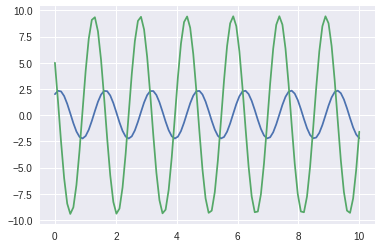

In [0]:
x = solveDiffEq([x0,xDot0],wSq,fCoefs,dT)
plt.plot(t,x)
fCoefs

In [0]:
nIt = 1 #number of iterations. 
CVec= np.zeros(nIt)
maxT=np.max(t)
for it in range(nIt):
    x = solveDiffEq([x0,xDot0],wSq,fCoefs,dT)
    x = x[:,0] #don't care about xdot
    x[np.isnan(x)] = 0.0001 #deal with nans in some arbitrary way (hopefully not necessary!)
    lambdaVec = np.array([])
    xVec = np.array([])
    for j in range(len(tData)-1): #need to solve lambda ode 49 times
        tStart = tData[j]
        tEnd = tData[j+1]
        tStartIndex = np.argmin(np.abs(t-tStart))
        tEndIndex = np.argmin(np.abs(t-tEnd))
        subX = x[tStartIndex:tEndIndex+1]
        lambdaSol = solveDiffEqLambda(subX[::-1],xData[j+1],wSq,fCoefs,dT,tStart,tEnd,maxT)
        lambdaRev = lambdaSol[:,0]
        lambdaVec = np.concatenate((lambdaVec,lambdaRev[::-1]))
        xVec = np.concatenate((xVec,subX))
    lambdaVec[np.isnan(lambdaVec)] = 0.0001
    CVec[it] = C(xVec,lambdaVec,wSq,fCoefs,dT,maxT) #so you can see how cost function decreases
    
    learningRate = 0.00001
    wSq = wSq - learningRate*dCdWSq(xVec,lambdaVec,dT)
    for i in range(len(fCoefs)):
        fCoefs[i] = fCoefs[i] - learningRate*dCdAlphaI(xVec, lambdaVec, dT,i)

ValueError: ignored

In [0]:
lambdaVec

array([ 0.26941267,  0.30757316,  0.29315124,  0.22861248,  0.12499036,
        0.        , -0.33189234, -0.37890265, -0.36113614, -0.28163015,
       -0.15397695,  0.        , -0.12853538, -0.1474017 , -0.1272136 ,
       -0.07331996,  0.        ,  0.82243818,  0.938931  ,  0.89490511,
        0.69788712,  0.38155906,  0.        , -0.93906315, -1.07689813,
       -0.9294064 , -0.53566623,  0.        ,  0.13485784,  0.15395954,
        0.14674048,  0.11443481,  0.06256548,  0.        ,  1.06546998,
        1.2163866 ,  1.15935097,  0.90411385,  0.49431033,  0.        ,
       -1.51848984, -1.73357367, -1.65228746, -1.28852782, -0.70448275,
        0.        ,  0.67111007,  0.76961509,  0.66420878,  0.38281877,
        0.        ,  0.91094285,  1.03997176,  0.99120813,  0.77298854,
        0.4226196 ,  0.        , -1.83256187, -2.09213188, -1.9940331 ,
       -1.5550364 , -0.8501922 ,  0.        ,  1.24608346,  1.42258276,
        1.35587873,  1.05737501,  0.5781035 ,  0.        ,  0.43

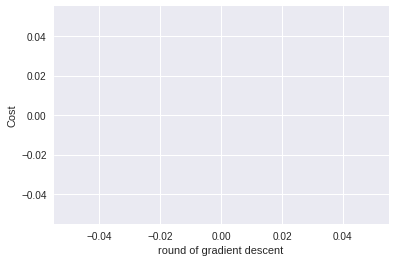

In [0]:
plt.figure()
plt.plot(CVec)
plt.xlabel('round of gradient descent')
plt.ylabel('Cost')
plt.show()

In [0]:
CVec

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])